# Regional Drought Climate Composites

This notebook creates composite maps of climate conditions during regional resource drought events.

**Research Question:** On days when a specific region is experiencing drought in a particular resource, what is the average spatial pattern of climate variables across the larger domain?

**Approach:**
- Use regional drought timelines (drought area fraction > 0.2 threshold)
- Load WRF climate data via climakitae for the full d02 domain
- Calculate climatology from full period
- Composite climate anomalies conditioned on drought days in selected region
- Analyze by season (DJF, MAM, JJA, SON) and all-year
- Per-model analysis with separate GWLs (0.8°C and 2.0°C)

**Climate Variables:**
- Precipitation (total)
- Air Temperature at 2m  
- Windspeed at 100m (for wind resource)
- Solar radiation (for PV resource)
- Additional variables as needed

## Setup and Imports

In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from renewable_data_load import *
from climakitae.core.data_interface import get_data

In [40]:
# Set larger default font sizes for plots
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 14

## Configuration

In [98]:
# Analysis parameters
drought_threshold = 0.2  # Regional drought when >20% of area in drought
target_gwls = [0.8, 2.0]
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]

# Regions to analyze
utility_regions = ["PG&E", "SCE", "SDG&E", "IID", "LDWP", "NCNC", "WECC_NW", "WECC_SW", "WECC_MTN"]

# Climate variable mapping (climakitae names)
climate_variables = {
    'precipitation': 'Precipitation (total)',
    'temperature': 'Air Temperature at 2m',
    'windspeed': 'Mean wind speed at 10m',
    'pressure': 'Surface Pressure',
    # 'solar': 'Surface Downwelling Shortwave Radiation'  # Need to verify
}

# Seasons for analysis (seasonal only, no annual)
seasons = {
    'DJF': [12, 1, 2],   # Winter
    'MAM': [3, 4, 5],    # Spring
    'JJA': [6, 7, 8],    # Summer
    'SON': [9, 10, 11],  # Fall
}

# Data paths
drought_data_dir = Path("drought_masks")
shapefile_dir = Path("../../data/load_zone_shapefiles")
domain = "d02"  # 9km resolution for larger spatial context
wrf_resolution = resolution_dict[domain]  # '9 km'

## Helper Functions

In [54]:
def load_region_shapefile(region, shapefile_dir=Path("../../data/load_zone_shapefiles")):
    """
    Load shapefile for a specific region.
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E', 'SCE')
    shapefile_dir : Path
        Directory containing shapefile
        
    Returns
    -------
    gpd.GeoDataFrame
        Region boundary geometry in geographic coordinates (lat/lon)
    """
    shapefile_path = shapefile_dir / "allLoadZones.shp"
    gdf = gpd.read_file(shapefile_path)
    
    # Filter to specific region using 'name' column
    region_gdf = gdf[gdf['name'] == region]
    
    if len(region_gdf) == 0:
        print(f"Warning: Region '{region}' not found in shapefile")
        print(f"Available regions: {gdf['name'].tolist()}")
        return None
    
    return region_gdf


def load_regional_drought_data(region, simulation, resource, module, gwl, data_dir):
    """
    Load drought area fraction time series for a specific region.
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E', 'SCE')
    simulation : str
        Climate model name
    resource : str
        'pv' or 'windpower'
    module : str
        'utility' or 'onshore'
    gwl : float
        Global warming level
    data_dir : Path
        Directory containing NetCDF files
        
    Returns
    -------
    xr.DataArray
        Drought area fraction time series
    """
    filename = f"{region}_{simulation}_{resource}_{module}_gwl{gwl}_drought_area_fraction.nc"
    filepath = data_dir / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    return xr.open_dataarray(filepath)

In [55]:
def get_drought_mask(drought_fraction, threshold=0.2):
    """
    Create binary drought mask from area fraction.
    
    Parameters
    ----------
    drought_fraction : xr.DataArray
        Drought area fraction time series
    threshold : float
        Threshold for regional drought
        
    Returns
    -------
    xr.DataArray
        Boolean mask where True = drought day
    """
    return drought_fraction > threshold

In [56]:
def get_seasonal_mask(time_index, season_months):
    """
    Create mask for specific season.
    
    Parameters
    ----------
    time_index : xr.DataArray or pd.DatetimeIndex
        Time coordinate
    season_months : list
        List of month numbers (1-12) for season
        
    Returns
    -------
    xr.DataArray or np.ndarray
        Boolean mask where True = day in season
    """
    if isinstance(time_index, xr.DataArray):
        months = time_index.dt.month
        # Use .isin() to preserve DataArray structure
        season_mask = months.isin(season_months)
    else:
        months = pd.DatetimeIndex(time_index).month
        season_mask = np.isin(months, season_months)
    
    return season_mask

In [57]:
def load_wrf_climate_data(climate_var_name, simulation, gwl, domain='d02'):
    """
    Load WRF climate data for specified variable, model, and GWL.
    
    Parameters
    ----------
    climate_var_name : str
        Climate variable name (climakitae convention)
    simulation : str
        Model name (e.g., 'ec-earth3')
    gwl : float
        Global warming level
    domain : str
        WRF domain (d02 or d03)
        
    Returns
    -------
    xr.DataArray
        Climate variable data with time, x, y dimensions
    """
    # Map simulation name to WRF naming convention
    wrf_simulation = sim_name_dict[simulation]
    wrf_resolution = resolution_dict[domain]
    
    # Determine scenarios based on GWL
    # For GWL analysis, we need both historical and future
    wrf_scenario = ['Historical Climate', 'SSP 3-7.0']
    
    print(f"Loading {climate_var_name} for {simulation} (GWL {gwl})...")
    
    # Load data
    wrfdat = get_data(
        variable=climate_var_name,
        downscaling_method="Dynamical",
        resolution=wrf_resolution,
        timescale="daily",
        scenario=wrf_scenario,
    )
    
    # Select simulation
    wrfdat = wrfdat.sel(simulation=wrf_simulation)
    
    # Convert calendar to noleap to match renewable data
    wrfdat = wrfdat.convert_calendar("noleap")
    
    # Get GWL crossing period
    # Extract ensemble member from simulation name
    # e.g., "WRF_EC-Earth3_r1i1p1f1" -> "r1i1p1f1"
    parts = wrf_simulation.split('_')
    model = parts[1]  # e.g., "EC-Earth3"
    ensemble = parts[2] if len(parts) > 2 else "r1i1p1f1"
    
    start_year, end_year = get_gwl_crossing_period(model, ensemble, gwl)
    
    # Crop to GWL period
    start_time = f"{start_year}-01-01"
    end_time = f"{end_year}-12-31"
    wrfdat = wrfdat.sel(time=slice(start_time, end_time))
    
    print(f"  Loaded {len(wrfdat.time)} days ({start_year}-{end_year})")
    
    return wrfdat

In [58]:
def calculate_seasonal_anomalies(climate_data, season_months):
    """
    Calculate anomalies from seasonal climatology.
    
    Parameters
    ----------
    climate_data : xr.DataArray
        Climate variable data (should already be filtered to season)
    season_months : list
        List of month numbers for the season (for verification)
        
    Returns
    -------
    xr.DataArray
        Anomalies (deviations from seasonal mean climatology)
    """
    # Calculate climatology for this season (mean of all days in the season)
    climatology = climate_data.mean('time', skipna=True)
    
    # Calculate anomalies
    anomalies = climate_data - climatology

    return anomalies

In [59]:
def create_drought_climate_composite(
    region,
    resource,
    climate_var,
    simulation,
    gwl,
    season,
    threshold=0.2,
    return_counts=False
):
    """
    Create composite map of climate anomalies during regional drought.
    
    APPROACH:
    1. Filter both drought data and climate data to the season
    2. Within seasonal subset, identify drought days (threshold exceedance)
    3. Calculate anomalies from seasonal climatology
    4. Composite anomalies on drought days only
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E')
    resource : str
        'pv' or 'windpower'
    climate_var : str
        Climate variable key (e.g., 'precipitation', 'temperature')
    simulation : str
        Climate model name
    gwl : float
        Global warming level (0.8 or 2.0)
    season : str
        Season name (DJF, MAM, JJA, SON)
    threshold : float
        Drought threshold for regional drought
    return_counts : bool
        If True, also return drought day count
        
    Returns
    -------
    composite : xr.DataArray
        Composite map of climate anomalies during drought
    n_drought_days : int (optional)
        Number of drought days in composite
    """
    # Determine module based on resource
    module = 'utility' if resource == 'pv' else 'onshore'
    
    # Get season months
    season_months = seasons[season]
    
    # Load regional drought data
    drought_fraction = load_regional_drought_data(
        region, simulation, resource, module, gwl, drought_data_dir
    )
    
    # Load climate data
    climate_var_name = climate_variables[climate_var]
    climate_data = load_wrf_climate_data(climate_var_name, simulation, gwl, domain='d02')
    
    # Align time indices first (both in noleap calendar)
    start_time = max(climate_data.time.values[0], drought_fraction.time.values[0])
    end_time = min(climate_data.time.values[-1], drought_fraction.time.values[-1])
    
    climate_data = climate_data.sel(time=slice(start_time, end_time))
    drought_fraction = drought_fraction.sel(time=slice(start_time, end_time))
    
    # Verify alignment
    if len(climate_data.time) != len(drought_fraction.time):
        climate_data = climate_data.reindex(time=drought_fraction.time, method='nearest')
    
    # STEP 1: Filter both to the season
    seasonal_mask = get_seasonal_mask(drought_fraction.time, season_months)
    
    drought_fraction_seasonal = drought_fraction.where(seasonal_mask, drop=True)
    climate_data_seasonal = climate_data.where(seasonal_mask, drop=True)
    
    # STEP 2: Within seasonal subset, identify drought days
    drought_mask = get_drought_mask(drought_fraction_seasonal, threshold)
    
    # STEP 3: Calculate anomalies from seasonal climatology
    climate_anomalies = calculate_seasonal_anomalies(climate_data_seasonal, season_months)
    
    # STEP 4: Select drought days and composite
    drought_anomalies = climate_anomalies.where(drought_mask, drop=True)
    
    # Calculate composite (mean over drought days)
    composite = drought_anomalies.mean(dim='time', skipna=True)
    
    # Compute now to avoid lazy evaluation during plotting
    composite = composite.compute()
    
    n_drought_days = drought_mask.sum().item()
    
    print(f"  {region} {resource} | {season}: {n_drought_days} drought days (of {len(drought_fraction_seasonal)} seasonal days)")
    

    if return_counts:       
        return composite, n_drought_days
    else:
         return composite

In [91]:
def create_coincident_drought_climate_composite(
    region,
    climate_var,
    simulation,
    gwl,
    season,
    threshold=0.2,
    return_counts=False
):
    """
    Create composite map of climate anomalies during coincident PV + wind drought.
    
    APPROACH:
    1. Load both PV and wind drought data for the region
    2. Identify days when BOTH resources are in drought
    3. Filter to season
    4. Calculate climate anomalies from seasonal climatology
    5. Composite anomalies on coincident drought days only
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E')
    climate_var : str
        Climate variable key (e.g., 'precipitation', 'temperature')
    simulation : str
        Climate model name
    gwl : float
        Global warming level (0.8 or 2.0)
    season : str
        Season name (DJF, MAM, JJA, SON)
    threshold : float
        Drought threshold for regional drought
    return_counts : bool
        If True, also return drought day count
        
    Returns
    -------
    composite : xr.DataArray
        Composite map of climate anomalies during coincident drought
    n_drought_days : int (optional)
        Number of coincident drought days in composite
    """
    # Get season months
    season_months = seasons[season]
    
    # Load PV drought data
    pv_drought_fraction = load_regional_drought_data(
        region, simulation, 'pv', 'utility', gwl, drought_data_dir
    )
    
    # Load wind drought data
    wind_drought_fraction = load_regional_drought_data(
        region, simulation, 'windpower', 'onshore', gwl, drought_data_dir
    )
    
    # Load climate data
    climate_var_name = climate_variables[climate_var]
    climate_data = load_wrf_climate_data(climate_var_name, simulation, gwl, domain='d02')
    
    # Align time indices (all in noleap calendar)
    start_time = max(
        climate_data.time.values[0],
        pv_drought_fraction.time.values[0],
        wind_drought_fraction.time.values[0]
    )
    end_time = min(
        climate_data.time.values[-1],
        pv_drought_fraction.time.values[-1],
        wind_drought_fraction.time.values[-1]
    )
    
    climate_data = climate_data.sel(time=slice(start_time, end_time))
    pv_drought_fraction = pv_drought_fraction.sel(time=slice(start_time, end_time))
    wind_drought_fraction = wind_drought_fraction.sel(time=slice(start_time, end_time))
    
    # Verify alignment
    if len(climate_data.time) != len(pv_drought_fraction.time):
        climate_data = climate_data.reindex(time=pv_drought_fraction.time, method='nearest')
    if len(wind_drought_fraction.time) != len(pv_drought_fraction.time):
        wind_drought_fraction = wind_drought_fraction.reindex(time=pv_drought_fraction.time, method='nearest')
    
    # STEP 1: Filter to the season
    seasonal_mask = get_seasonal_mask(pv_drought_fraction.time, season_months)
    
    pv_drought_seasonal = pv_drought_fraction.where(seasonal_mask, drop=True)
    wind_drought_seasonal = wind_drought_fraction.where(seasonal_mask, drop=True)
    climate_data_seasonal = climate_data.where(seasonal_mask, drop=True)
    
    # STEP 2: Identify days when BOTH PV and wind are in drought
    pv_drought_mask = get_drought_mask(pv_drought_seasonal, threshold)
    wind_drought_mask = get_drought_mask(wind_drought_seasonal, threshold)
    
    # Coincident drought: both PV AND wind in drought
    coincident_drought_mask = pv_drought_mask & wind_drought_mask
    
    # STEP 3: Calculate anomalies from seasonal climatology
    climate_anomalies = calculate_seasonal_anomalies(climate_data_seasonal, season_months)
    
    # STEP 4: Select coincident drought days and composite
    coincident_drought_anomalies = climate_anomalies.where(coincident_drought_mask, drop=True)
    
    # Calculate composite (mean over coincident drought days)
    composite = coincident_drought_anomalies.mean(dim='time', skipna=True)
    
    # Compute now to avoid lazy evaluation during plotting
    composite = composite.compute()
    
    n_coincident_drought_days = coincident_drought_mask.sum().item()
    n_pv_drought_days = pv_drought_mask.sum().item()
    n_wind_drought_days = wind_drought_mask.sum().item()
    
    print(f"  {region} | {season}:")
    print(f"    PV drought: {n_pv_drought_days} days")
    print(f"    Wind drought: {n_wind_drought_days} days")
    print(f"    Coincident (PV+Wind): {n_coincident_drought_days} days (of {len(pv_drought_seasonal)} seasonal days)")
    
    if return_counts:
        return composite, n_coincident_drought_days
    else:
        return composite

In [102]:
def plot_coincident_drought_composite(
    composite,
    region,
    climate_var,
    simulation,
    gwl,
    season,
    shapefile_dir,
    n_drought_days=None,
    cmap='BrBG',
    vmax=None,
    save=False
):
    """
    Plot composite map of climate anomalies during coincident PV + wind drought.
    
    Parameters
    ----------
    composite : xr.DataArray
        Composite map from create_coincident_drought_climate_composite()
    region : str
        Region name
    climate_var : str
        Climate variable key
    simulation : str
        Model name
    gwl : float
        Global warming level
    season : str
        Season name
    shapefile_dir : pathlib.Path
        Directory containing region shapefiles
    n_drought_days : int, optional
        Number of coincident drought days to display in title
    cmap : str
        Colormap name
    vmax : float, optional
        Maximum value for colorbar (symmetric around 0)
    save : bool
        Whether to save figure
    """
    # Check if data has lat/lon or x/y coordinates
    has_latlon = 'lat' in composite.coords and 'lon' in composite.coords
    
    # WRF Lambert Conformal projection
    wrf_proj = ccrs.LambertConformal(
        central_longitude=-97,
        central_latitude=38,
        standard_parallels=(30, 60)
    )
    
    if has_latlon:
        # Data already has lat/lon coordinates
        fig, ax = plt.subplots(
            1, 1, figsize=(12, 10),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )
        data_crs = ccrs.PlateCarree()
    else:
        # Data is in WRF projection (x, y coordinates)
        fig, ax = plt.subplots(
            1, 1, figsize=(12, 10),
            subplot_kw={'projection': wrf_proj}
        )
        data_crs = wrf_proj
    
    # Determine colorbar limits
    if vmax is None:
        vmax = np.nanpercentile(np.abs(composite.values), 95)
    
    # Create diverging norm centered at 0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    # Plot composite
    if has_latlon:
        im = composite.plot(
            ax=ax,
            x='lon',
            y='lat',
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=False
        )
    else:
        # For x/y data, use pcolormesh with the native projection
        im = ax.pcolormesh(
            composite.x,
            composite.y,
            composite.values,
            cmap=cmap,
            norm=norm,
            transform=data_crs
        )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    
    # Get units from data
    units = composite.attrs.get('units', '')
    cbar.set_label(f'{climate_var.title()} Anomaly ({units})', fontsize=11)
    
    # Add geographic features
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    
    # Add region boundary
    try:
        region_gdf = load_region_shapefile(region, shapefile_dir)
        if region_gdf is not None:
            region_gdf.plot(
                ax=ax,
                facecolor='none',
                edgecolor='magenta',
                linewidth=1,
                linestyle='-',
                transform=ccrs.PlateCarree()
            )
    except Exception as e:
        print(f"Could not load region boundary: {e}")
    
    # Set extent to full WECC d02 region
    ax.set_extent([-130, -95, 28, 56], crs=ccrs.PlateCarree())
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3, linestyle='--', crs=ccrs.PlateCarree())
    gl.top_labels = False
    gl.right_labels = False
    
    # Title
    title = f'Coincident PV+Wind Drought: {climate_var.title()} Anomaly\n'
    title += f'{region} | {simulation} | GWL {gwl}°C | {season}'
    if n_drought_days is not None:
        title += f' | n={n_drought_days} days'
    
    ax.set_title(title, fontsize=13, pad=10)
    
    plt.tight_layout()
    
    if save:
        filename = f'coincident_composite_{region}_{climate_var}_{simulation}_gwl{gwl}_{season}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()

## Test the Framework

Let's test with a single case to verify everything works.

In [20]:
# Test case: PG&E region, PV resource, precipitation, one model and GWL
test_region = "PG&E"
test_resource = "pv"
test_climate_var = "precipitation"
test_simulation = "ec-earth3"
test_gwl = 0.8
test_season = "JJA"  # Summer

print(f"Testing composite creation...")
print(f"Region: {test_region}")
print(f"Resource: {test_resource}")
print(f"Climate variable: {test_climate_var}")
print(f"Model: {test_simulation}")
print(f"GWL: {test_gwl}°C")
print(f"Season: {test_season}")
print()

composite, n_days = create_drought_climate_composite(
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    return_counts=True
)

print(f"\n✓ Composite created successfully!")
print(f"Shape: {composite.shape}")
print(f"Drought days: {n_days}")
print(f"Coordinate dims: {list(composite.dims)}")
#print(f"Data range: {float(composite.min():.2f)} to {float(composite.max():.2f)}")
print(f"Number of valid points: {(~np.isnan(composite.values)).sum()}")

Testing composite creation...
Region: PG&E
Resource: pv
Climate variable: precipitation
Model: ec-earth3
GWL: 0.8°C
Season: JJA

Loading Precipitation (total) for ec-earth3 (GWL 0.8)...


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:550: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  all_hist = xr.concat(
/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:591: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  one_scenario = xr.concat

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (1988-2017)
  PG&E pv | JJA: 175 drought days (of 2760 seasonal days)

✓ Composite created successfully!
Shape: (1, 320, 250)
Drought days: 175
Coordinate dims: ['scenario', 'y', 'x']
Number of valid points: 80000


## Visualization Function

In [64]:
def plot_drought_composite(
    composite,
    region,
    resource,
    climate_var,
    simulation,
    gwl,
    season,
    n_drought_days=None,
    vmax=None,
    cmap='RdBu_r',
    save=False,
    show_region=True
):
    """
    Plot composite map of climate anomalies during drought.
    
    Parameters
    ----------
    composite : xr.DataArray
        Composite map data
    region : str
        Region name
    resource : str
        Resource type
    climate_var : str
        Climate variable name
    simulation : str
        Model name
    gwl : float
        Global warming level
    season : str
        Season name
    n_drought_days : int, optional
        Number of drought days
    vmax : float, optional
        Maximum value for colorbar (symmetric around 0)
    cmap : str
        Colormap name
    save : bool
        Whether to save figure
    show_region : bool
        Whether to show region boundary outline
    """
    # Check if data has lat/lon or x/y coordinates
    has_latlon = 'lat' in composite.coords and 'lon' in composite.coords
    
    # WRF Lambert Conformal projection
    wrf_proj = ccrs.LambertConformal(
        central_longitude=-97,
        central_latitude=38,
        standard_parallels=(30, 60)
    )
    
    if has_latlon:
        # Data already has lat/lon coordinates
        fig, ax = plt.subplots(
            1, 1, figsize=(12, 10),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )
        data_crs = ccrs.PlateCarree()
    else:
        # Data is in WRF projection (x, y coordinates)
        fig, ax = plt.subplots(
            1, 1, figsize=(12, 10),
            subplot_kw={'projection': wrf_proj}
        )
        data_crs = wrf_proj
    
    # Determine colorbar limits
    if vmax is None:
        vmax = np.nanpercentile(np.abs(composite.values), 95)
    
    # Create diverging norm centered at 0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    # Plot composite
    if has_latlon:
        im = composite.plot(
            ax=ax,
            x='lon',
            y='lat',
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=False
        )
    else:
        # For x/y data, use pcolormesh with the native projection
        im = ax.pcolormesh(
            composite.x,
            composite.y,
            composite.values,
            cmap=cmap,
            norm=norm,
            transform=data_crs
        )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    
    # Get units from data
    units = composite.attrs.get('units', '')
    cbar.set_label(f'{climate_var.title()} Anomaly ({units})', fontsize=11)
    
    # Add geographic features
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    
    # Add region boundary if requested
    if show_region:
        try:
            region_gdf = load_region_shapefile(region)
            if region_gdf is not None:
                region_gdf.plot(
                    ax=ax,
                    facecolor='none',
                    edgecolor='magenta',
                    linewidth=1,
                    linestyle='-',
                    transform=ccrs.PlateCarree()
                )
        except Exception as e:
            print(f"Could not load region boundary: {e}")
    
    # Set extent to California + context
    ax.set_extent([-126, -113, 31, 43], crs=ccrs.PlateCarree())

    # Set extent to full WECC d02 region
    ax.set_extent([-130, -95, 28, 56], crs=ccrs.PlateCarree())
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3, linestyle='--', crs=ccrs.PlateCarree())
    gl.top_labels = False
    gl.right_labels = False
    
    # Title
    title = f'{climate_var.title()} Anomaly During {resource.upper()} Drought\n'
    title += f'{region} | {simulation} | GWL {gwl}°C | {season}'
    if n_drought_days is not None:
        title += f' | n={n_drought_days} days'
    
    ax.set_title(title, fontsize=13, pad=10)
    
    plt.tight_layout()
    
    if save:
        filename = f'composite_{region}_{resource}_{climate_var}_{simulation}_gwl{gwl}_{season}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    
    plt.show()

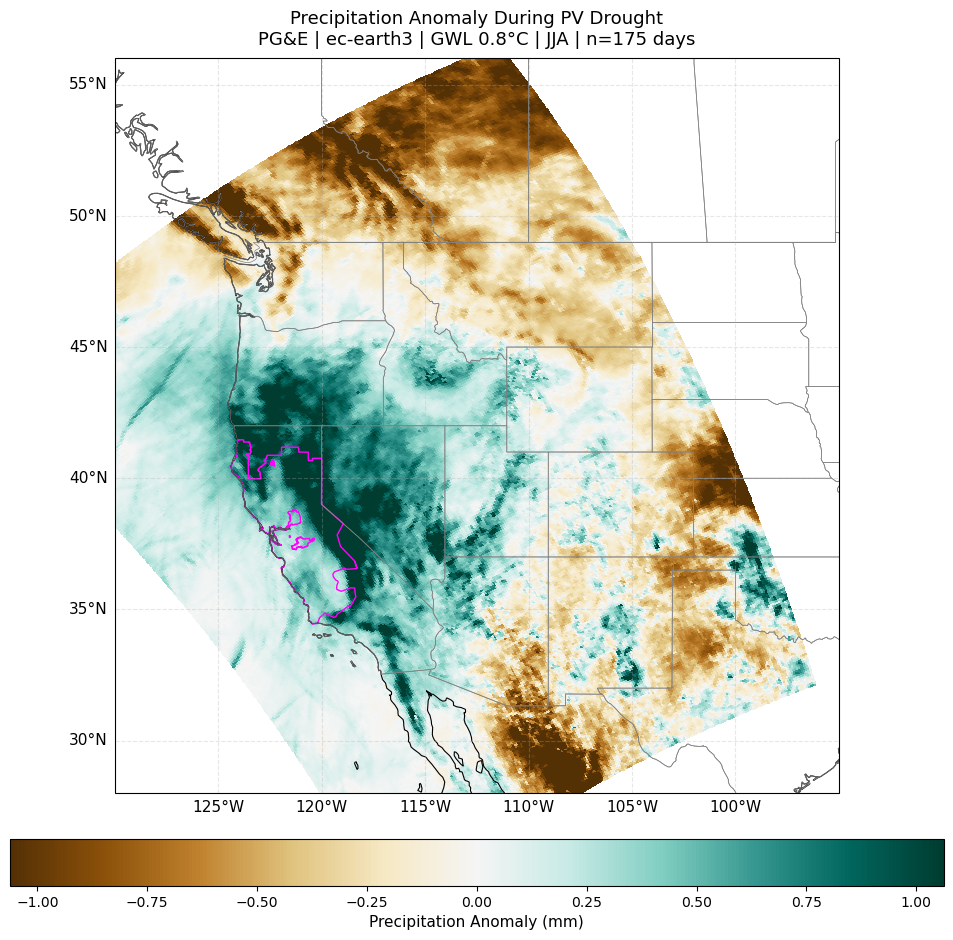

In [65]:
# Plot the test composite
plot_drought_composite(
    composite=composite,
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    n_drought_days=n_days,
    save=False,
    cmap='BrBG',
    show_region=True
)

In [88]:
# Test case: PG&E region, PV resource, precipitation, one model and GWL
test_region = "SCE"
test_resource = "pv"
test_climate_var = "precipitation"
test_simulation = "ec-earth3"
test_gwl = 2.0
test_season = "DJF"  # Summer

print(f"Testing composite creation...")
print(f"Region: {test_region}")
print(f"Resource: {test_resource}")
print(f"Climate variable: {test_climate_var}")
print(f"Model: {test_simulation}")
print(f"GWL: {test_gwl}°C")
print(f"Season: {test_season}")
print()

composite, n_days = create_drought_climate_composite(
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    return_counts=True
)

print(f"\n✓ Composite created successfully!")
print(f"Shape: {composite.shape}")
print(f"Drought days: {n_days}")
print(f"Coordinate dims: {list(composite.dims)}")
#print(f"Data range: {float(composite.min():.2f)} to {float(composite.max():.2f)}")
print(f"Number of valid points: {(~np.isnan(composite.values)).sum()}")

Testing composite creation...
Region: SCE
Resource: pv
Climate variable: precipitation
Model: ec-earth3
GWL: 2.0°C
Season: DJF

Loading Precipitation (total) for ec-earth3 (GWL 2.0)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (2017-2046)
  SCE pv | DJF: 212 drought days (of 2700 seasonal days)

✓ Composite created successfully!
Shape: (1, 320, 250)
Drought days: 212
Coordinate dims: ['scenario', 'y', 'x']
Number of valid points: 80000


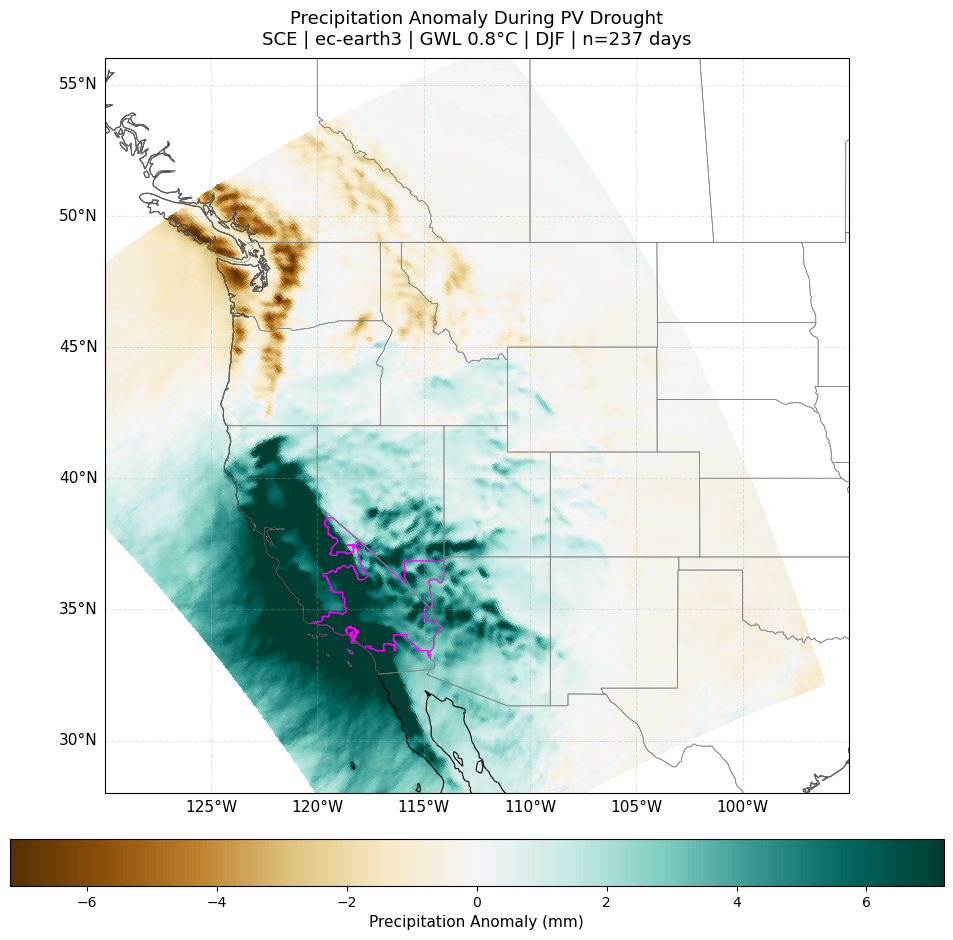

In [73]:
# Plot the test composite
plot_drought_composite(
    composite=composite,
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    n_drought_days=n_days,
    save=False,
    cmap='BrBG',
    show_region=True
)

In [113]:
# Test case: PG&E region, PV resource, precipitation, one model and GWL
test_region = "SCE"
test_resource = "pv"
test_climate_var = "pressure"
test_simulation = "ec-earth3"
test_gwl = 0.8
test_season = "DJF"  # Summer

print(f"Testing composite creation...")
print(f"Region: {test_region}")
print(f"Resource: {test_resource}")
print(f"Climate variable: {test_climate_var}")
print(f"Model: {test_simulation}")
print(f"GWL: {test_gwl}°C")
print(f"Season: {test_season}")
print()

composite, n_days = create_drought_climate_composite(
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    return_counts=True
)

print(f"\n✓ Composite created successfully!")
print(f"Shape: {composite.shape}")
print(f"Drought days: {n_days}")
print(f"Coordinate dims: {list(composite.dims)}")
#print(f"Data range: {float(composite.min():.2f)} to {float(composite.max():.2f)}")
print(f"Number of valid points: {(~np.isnan(composite.values)).sum()}")

Testing composite creation...
Region: SCE
Resource: pv
Climate variable: pressure
Model: ec-earth3
GWL: 0.8°C
Season: DJF

Loading Surface Pressure for ec-earth3 (GWL 0.8)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (1988-2017)
  SCE pv | DJF: 237 drought days (of 2700 seasonal days)

✓ Composite created successfully!
Shape: (1, 320, 250)
Drought days: 237
Coordinate dims: ['scenario', 'y', 'x']
Number of valid points: 80000


Saved: composite_SCE_pv_pressure_ec-earth3_gwl0.8_DJF.png


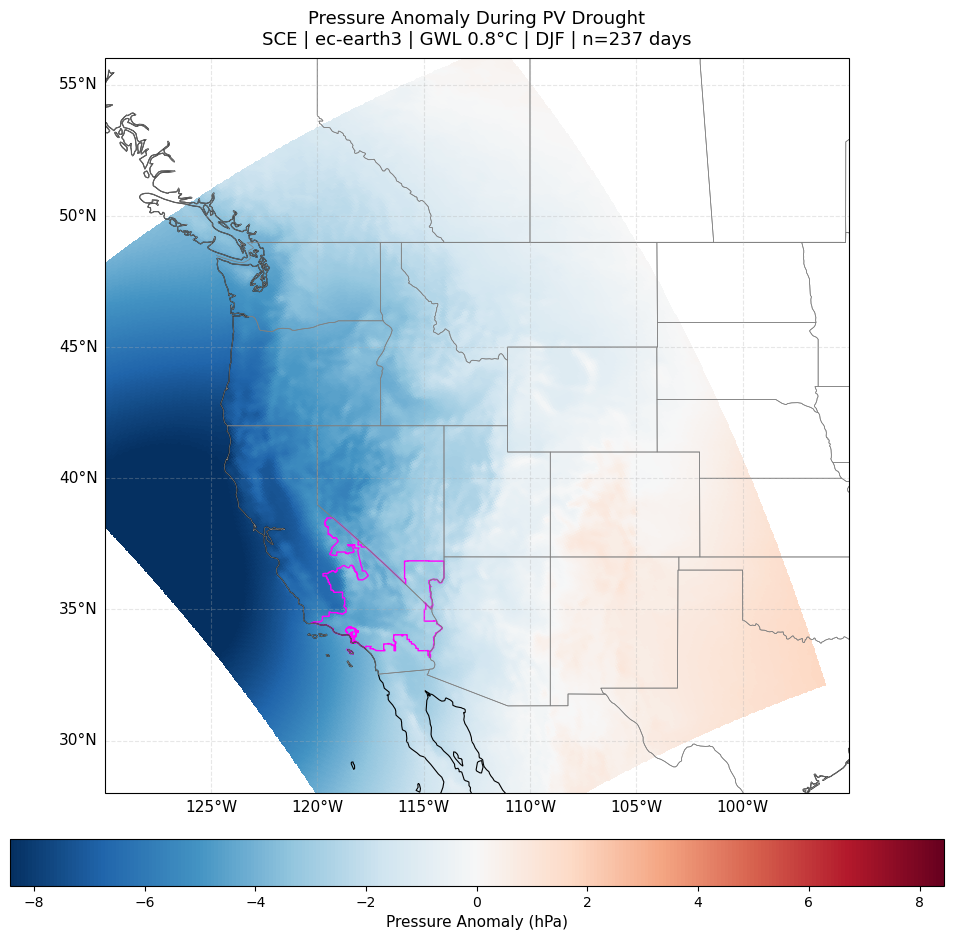

In [114]:
# Plot the test composite
plot_drought_composite(
    composite=composite,
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    n_drought_days=n_days,
    save=True,
    cmap='RdBu_r',
    show_region=True
)

In [115]:
# Test case: PG&E region, PV resource, precipitation, one model and GWL
test_region = "SCE"
test_resource = "windpower"
test_climate_var = "pressure"
test_simulation = "ec-earth3"
test_gwl = 0.8
test_season = "DJF"  # Summer

print(f"Testing composite creation...")
print(f"Region: {test_region}")
print(f"Resource: {test_resource}")
print(f"Climate variable: {test_climate_var}")
print(f"Model: {test_simulation}")
print(f"GWL: {test_gwl}°C")
print(f"Season: {test_season}")
print()

composite, n_days = create_drought_climate_composite(
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    return_counts=True
)

print(f"\n✓ Composite created successfully!")
print(f"Shape: {composite.shape}")
print(f"Drought days: {n_days}")
print(f"Coordinate dims: {list(composite.dims)}")
#print(f"Data range: {float(composite.min():.2f)} to {float(composite.max():.2f)}")
print(f"Number of valid points: {(~np.isnan(composite.values)).sum()}")

Testing composite creation...
Region: SCE
Resource: windpower
Climate variable: pressure
Model: ec-earth3
GWL: 0.8°C
Season: DJF

Loading Surface Pressure for ec-earth3 (GWL 0.8)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (1988-2017)
  SCE windpower | DJF: 59 drought days (of 2700 seasonal days)

✓ Composite created successfully!
Shape: (1, 320, 250)
Drought days: 59
Coordinate dims: ['scenario', 'y', 'x']
Number of valid points: 80000


Saved: composite_SCE_windpower_pressure_ec-earth3_gwl0.8_DJF.png


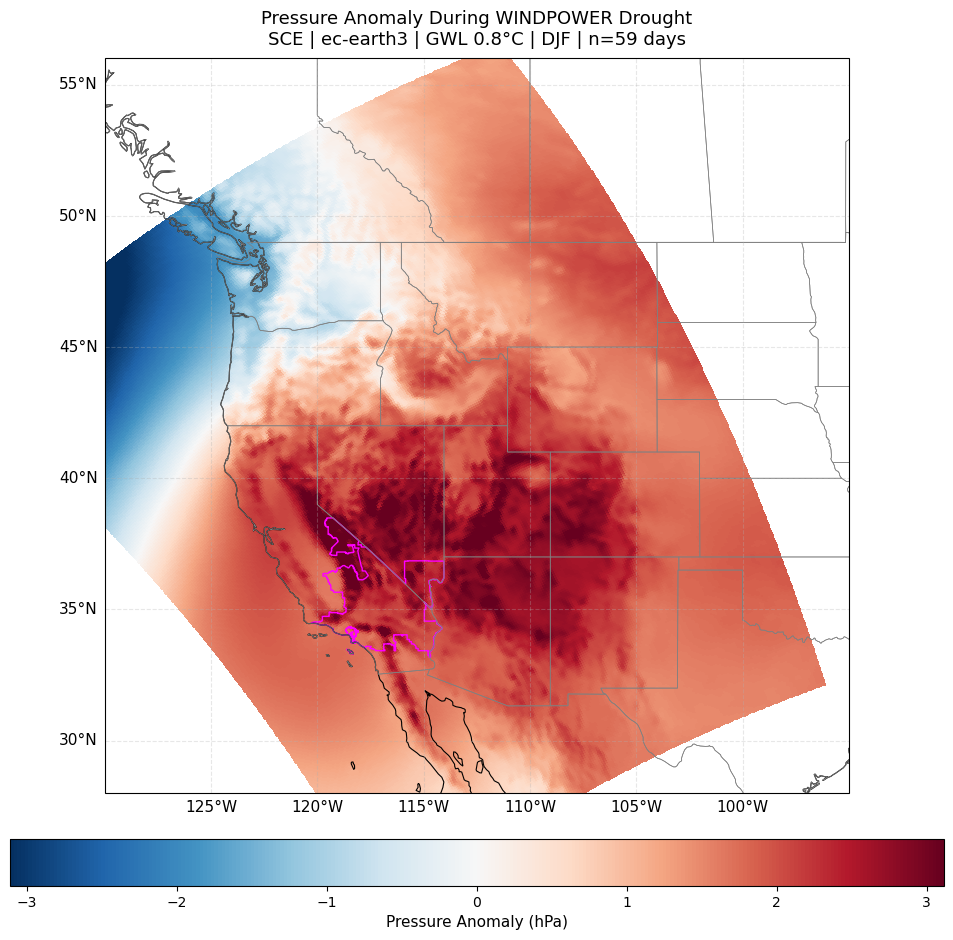

In [116]:
# Plot the test composite
plot_drought_composite(
    composite=composite,
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    n_drought_days=n_days,
    save=True,
    cmap='RdBu_r',
    show_region=True
)

In [84]:
# Test case: PG&E region, PV resource, precipitation, one model and GWL
test_region = "SCE"
test_resource = "windpower"
test_climate_var = "windspeed"
test_simulation = "ec-earth3"
test_gwl = 0.8
test_season = "DJF"  # Summer

print(f"Testing composite creation...")
print(f"Region: {test_region}")
print(f"Resource: {test_resource}")
print(f"Climate variable: {test_climate_var}")
print(f"Model: {test_simulation}")
print(f"GWL: {test_gwl}°C")
print(f"Season: {test_season}")
print()

composite, n_days = create_drought_climate_composite(
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    return_counts=True
)

print(f"\n✓ Composite created successfully!")
print(f"Shape: {composite.shape}")
print(f"Drought days: {n_days}")
print(f"Coordinate dims: {list(composite.dims)}")
#print(f"Data range: {float(composite.min():.2f)} to {float(composite.max():.2f)}")
print(f"Number of valid points: {(~np.isnan(composite.values)).sum()}")

Testing composite creation...
Region: SCE
Resource: windpower
Climate variable: windspeed
Model: ec-earth3
GWL: 0.8°C
Season: DJF

Loading Mean wind speed at 10m for ec-earth3 (GWL 0.8)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (1988-2017)
  SCE windpower | DJF: 59 drought days (of 2700 seasonal days)

✓ Composite created successfully!
Shape: (1, 320, 250)
Drought days: 59
Coordinate dims: ['scenario', 'y', 'x']
Number of valid points: 80000


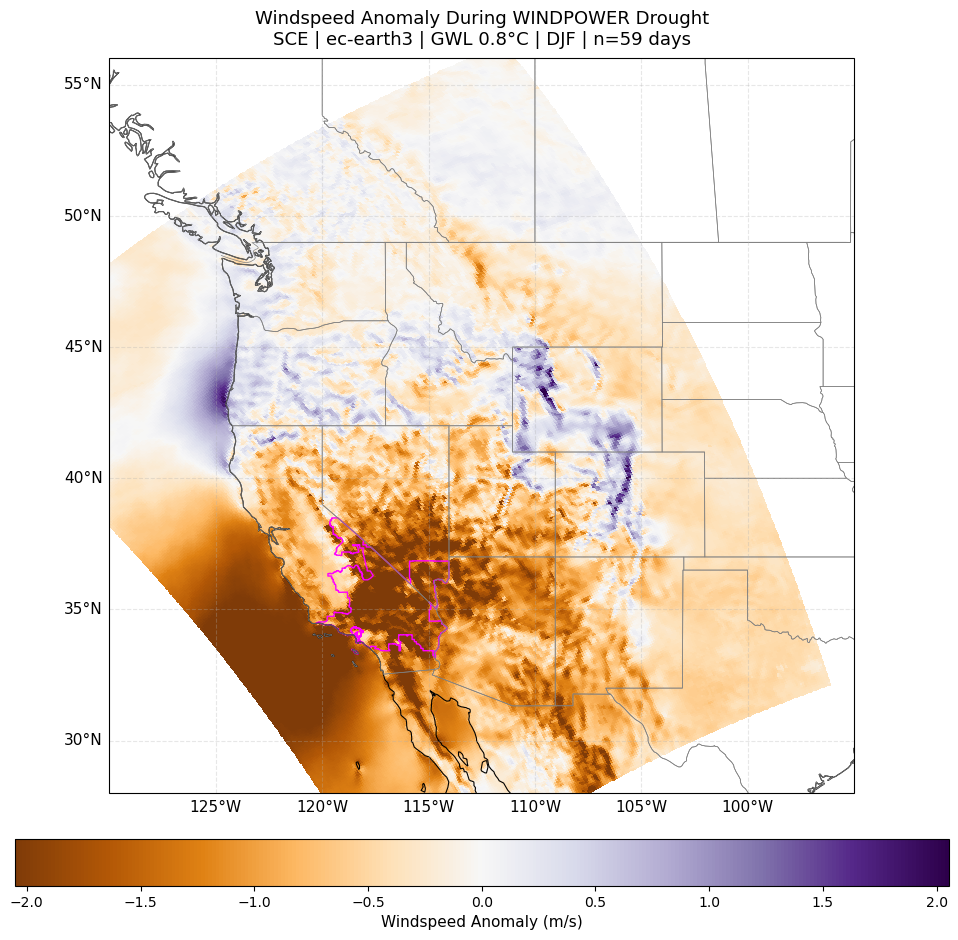

In [85]:
# Plot the test composite
plot_drought_composite(
    composite=composite,
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    n_drought_days=n_days,
    save=False,
    cmap='PuOr',
    show_region=True
)

In [86]:
# Test case: PG&E region, PV resource, precipitation, one model and GWL
test_region = "SCE"
test_resource = "pv"
test_climate_var = "windspeed"
test_simulation = "ec-earth3"
test_gwl = 0.8
test_season = "DJF"  # Summer

print(f"Testing composite creation...")
print(f"Region: {test_region}")
print(f"Resource: {test_resource}")
print(f"Climate variable: {test_climate_var}")
print(f"Model: {test_simulation}")
print(f"GWL: {test_gwl}°C")
print(f"Season: {test_season}")
print()

composite, n_days = create_drought_climate_composite(
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    return_counts=True
)

print(f"\n✓ Composite created successfully!")
print(f"Shape: {composite.shape}")
print(f"Drought days: {n_days}")
print(f"Coordinate dims: {list(composite.dims)}")
#print(f"Data range: {float(composite.min():.2f)} to {float(composite.max():.2f)}")
print(f"Number of valid points: {(~np.isnan(composite.values)).sum()}")

Testing composite creation...
Region: SCE
Resource: pv
Climate variable: windspeed
Model: ec-earth3
GWL: 0.8°C
Season: DJF

Loading Mean wind speed at 10m for ec-earth3 (GWL 0.8)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (1988-2017)
  SCE pv | DJF: 237 drought days (of 2700 seasonal days)

✓ Composite created successfully!
Shape: (1, 320, 250)
Drought days: 237
Coordinate dims: ['scenario', 'y', 'x']
Number of valid points: 80000


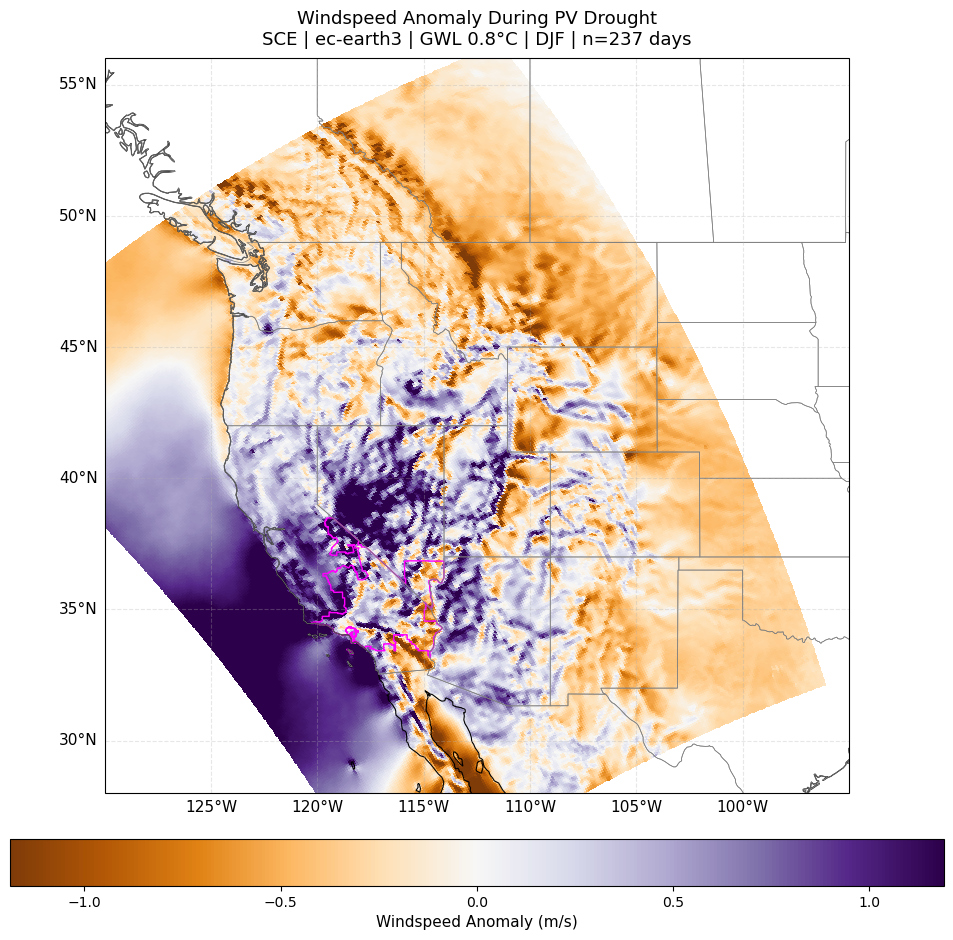

In [87]:
# Plot the test composite
plot_drought_composite(
    composite=composite,
    region=test_region,
    resource=test_resource,
    climate_var=test_climate_var,
    simulation=test_simulation,
    gwl=test_gwl,
    season=test_season,
    n_drought_days=n_days,
    save=False,
    cmap='PuOr',
    show_region=True
)

## Systematic Analysis

Now that the framework works, we can systematically explore different combinations.

## Test Case: Coincident PV + Wind Drought Composites

Test the new coincident drought composite function that identifies days when BOTH PV and wind are in drought simultaneously.

In [117]:
# Test parameters - try different season/region to find coincident droughts
test_region_coincident = 'SCE'  # Southern California Edison
test_simulation_coincident = "ec-earth3"
test_gwl_coincident = 0.8
test_season_coincident = 'DJF'  # Summer - more likely for coincident droughts?
test_climate_var_coincident = 'pressure'

print(f"Testing coincident drought composite:")
print(f"  Region: {test_region_coincident}")
print(f"  Climate Model: {test_simulation_coincident}")
print(f"  GWL: {test_gwl_coincident}")
print(f"  Season: {test_season_coincident}")
print(f"  Climate Variable: {test_climate_var_coincident}")
print()

# Create composite
composite_coincident, n_days_coincident = create_coincident_drought_climate_composite(
    region=test_region_coincident,
    climate_var=test_climate_var_coincident,
    simulation=test_simulation_coincident,
    gwl=test_gwl_coincident,
    season=test_season_coincident,
    threshold=0.2,
    return_counts=True
)

print(f"\nComposite shape: {composite_coincident.shape}")
print(f"Composite value range: {composite_coincident.min().values:.2f} to {composite_coincident.max().values:.2f}")

Testing coincident drought composite:
  Region: SCE
  Climate Model: ec-earth3
  GWL: 0.8
  Season: DJF
  Climate Variable: pressure

Loading Surface Pressure for ec-earth3 (GWL 0.8)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  Loaded 10950 days (1988-2017)
  SCE | DJF:
    PV drought: 237 days
    Wind drought: 59 days
    Coincident (PV+Wind): 1 days (of 2700 seasonal days)

Composite shape: (1, 320, 250)
Composite value range: -7.10 to 17.31
